In [162]:
import os
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchinfo

In [163]:
batch_size = 100
random_seed = 42

data_path = Path('./data')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [164]:
print('torch version:', torch.__version__)
print('device:', device)
print(torch.cuda.device_count(),'GPU(s) availabe')

torch version: 2.1.0
device: cuda:0
1 GPU(s) availabe


In [165]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [258]:
train_data = pd.read_csv(data_path/'train.csv')

print('train:',train_data.shape)

train: (42000, 785)


In [167]:
x = train_data.iloc[:,train_data.columns!='label']
y = train_data.label.values

print('X:',x.shape,type(x))
print('Y:',y.shape,type(y))

X: (42000, 784) <class 'pandas.core.frame.DataFrame'>
Y: (42000,) <class 'numpy.ndarray'>


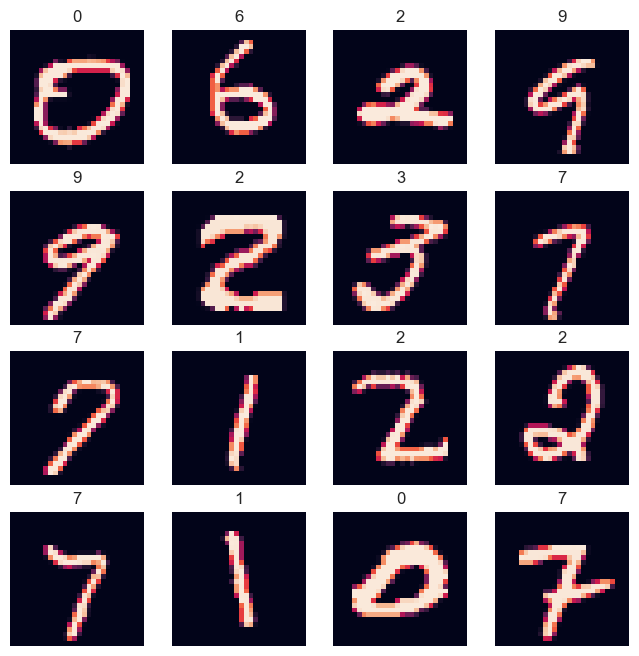

In [168]:
fig = plt.figure(figsize=(8,8))
cols, rows = 4,4

for i in range(1,cols*rows+1):
    sample = np.random.randint(0,len(x)-1)
    label = str(int(y[sample]))
    img = x.values[sample].reshape(28,28)
    
    fig.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

In [169]:
train_data.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [170]:
class DigitRecognizerModel(nn.Module):
    """
    Architecture summary:
      - Layer 1: Convolution 1 > Activation (ReLU) > Pooling 1 > Dropout 1
      - Layer 2: Convolution 2 > Activation (ReLU) > Pooling 2 > Dropout 2 > Flatten
      - Layer 3: Linear 1 > Activation (ReLU) > Dropout 3
      - Layer 4: Linear 2 > Activation (ReLU) > Dropout 4
      - Layer 5: Output > Activation (Softmax)
    """
    
    def __init__(self):
        super().__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=128,kernel_size=5,stride=1,padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop1 = nn.Dropout(p=0.3)
        
        # layer 2
        self.conv2 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,stride=1,padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop2 = nn.Dropout2d(p=0.4)
        
        # layer 3
        self.linear1 = nn.Linear(in_features=256*4*4,out_features=64)
        self.drop3 = nn.Dropout(p=0.4)
        
        # layer 4
        self.linear2 = nn.Linear(in_features=64,out_features=32)
        self.drop4 = nn.Dropout(p=0.4)
        
        # layer 5
        self.linear3 = nn.Linear(in_features=32,out_features=10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        out = self.drop1(self.pool1(F.relu(self.conv1(x))))
        out = self.drop2(self.pool2(F.relu(self.conv2(out))))
        out = out.view(-1,256*4*4)
        out = self.drop3(F.relu(self.linear1(out)))
        out = self.drop4(F.relu(self.linear2(out)))
        out = self.linear3(out)
        return out

In [171]:
model = DigitRecognizerModel().to(device)
loss_func = nn.CrossEntropyLoss()
lr = 0.00100
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

DigitRecognizerModel(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.4, inplace=False)
  (linear1): Linear(in_features=4096, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [172]:
torchinfo.summary(model,(1,28,28),col_names=('input_size', 'output_size', 'num_params', 'kernel_size'))

E:\anaconda3\lib\site-packages\torch\nn\functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
DigitRecognizerModel                     [1, 28, 28]               [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 28, 28]               [128, 24, 24]             3,328                     [5, 5]
├─MaxPool2d: 1-2                         [128, 24, 24]             [128, 12, 12]             --                        [2, 2]
├─Dropout: 1-3                           [128, 12, 12]             [128, 12, 12]             --                        --
├─Conv2d: 1-4                            [128, 12, 12]             [256, 8, 8]               819,456                   [5, 5]
├─MaxPool2d: 1-5                         [256, 8, 8]               [256, 4, 4]               --                        [2, 2]
├─Dropout2d: 1-6                         [256, 4, 4]               [256, 4, 4]               --                        -

In [173]:
def train_loop(dataloader,model,loss_func,optimizer,print_every=100):
    size = len(dataloader.dataset)
    model.train()                        # 训练模式
    
    train_losses = 0
    
    for batch, (x,y) in enumerate(dataloader):
        x = (x.view(-1,1,28,28)).type(torch.FloatTensor).to(device)
        y = y.to(device)
        logits = model(x)
        loss = loss_func(logits,y)
        train_losses += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % print_every == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
            
    train_losses /= size

    return float(train_losses)

In [174]:
def valid_loop(dataloader, model, loss_func, print_every=100):
    size = len(dataloader.dataset)
    model.eval()
    batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x = (x.view(-1, 1, 28, 28)).type(torch.FloatTensor).to(device)
            y = y.to(device)
            logits = model(x)
            loss += loss_func(logits, y).item()
            correct += (logits.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size
    print(f'Validation: Accuracy={(100*correct):>0.1f}%, Average_Loss={loss:>8f}\n')
    
    return loss

X: (42000, 784) <class 'pandas.core.frame.DataFrame'>
Y: (42000,) <class 'numpy.ndarray'>
Fold 1
Epoch 1
-------------------------------
loss: 2.312701 [  100/21000]
loss: 0.762102 [10100/21000]
loss: 0.417900 [20100/21000]
Validation: Accuracy=95.6%, Average_Loss=0.001584

final :  0.010619680397212505   0.0015840890794282868
Epoch 2
-------------------------------
loss: 0.512418 [  100/21000]
loss: 0.316185 [10100/21000]
loss: 0.279647 [20100/21000]
Validation: Accuracy=97.1%, Average_Loss=0.001012

final :  0.0039030471816658974   0.001011746258253143
Epoch 3
-------------------------------
loss: 0.257525 [  100/21000]
loss: 0.302063 [10100/21000]
loss: 0.243575 [20100/21000]
Validation: Accuracy=97.6%, Average_Loss=0.000854

final :  0.0028427124489098787   0.0008544032470478366
Epoch 4
-------------------------------
loss: 0.402011 [  100/21000]
loss: 0.407795 [10100/21000]
loss: 0.182049 [20100/21000]
Validation: Accuracy=98.1%, Average_Loss=0.000703

final :  0.00241465168073773

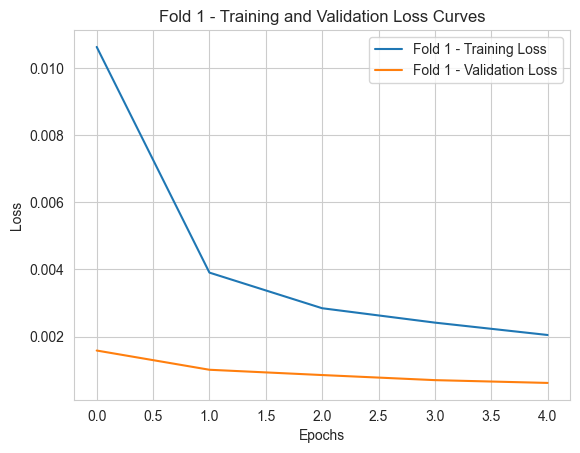

Fold 2
Epoch 1
-------------------------------
loss: 0.260286 [  100/21000]
loss: 0.182506 [10100/21000]
loss: 0.228471 [20100/21000]
Validation: Accuracy=98.9%, Average_Loss=0.000402

final :  0.002044237917289138   0.00040190809194575106
Epoch 2
-------------------------------
loss: 0.152726 [  100/21000]
loss: 0.216077 [10100/21000]
loss: 0.196644 [20100/21000]
Validation: Accuracy=98.8%, Average_Loss=0.000415

final :  0.0017437970964238048   0.000414648173623261
Epoch 3
-------------------------------
loss: 0.142287 [  100/21000]
loss: 0.151766 [10100/21000]
loss: 0.224699 [20100/21000]
Validation: Accuracy=98.9%, Average_Loss=0.000390

final :  0.0016272161155939102   0.00038962560355208727
Epoch 4
-------------------------------
loss: 0.117051 [  100/21000]
loss: 0.217393 [10100/21000]
loss: 0.207887 [20100/21000]
Validation: Accuracy=99.0%, Average_Loss=0.000390

final :  0.0014975457452237606   0.0003904193461300262
Epoch 5
-------------------------------
loss: 0.085119 [  100

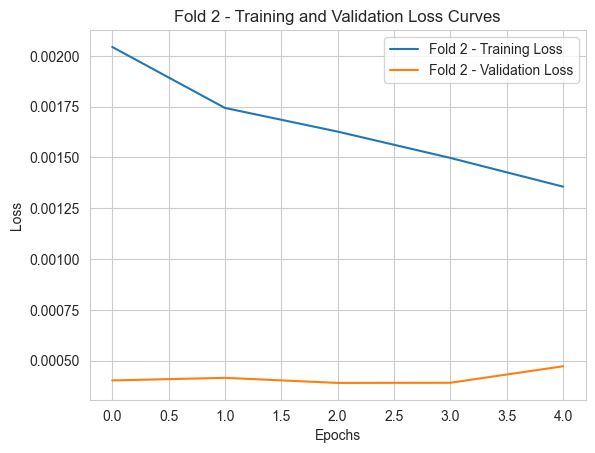

In [176]:
from sklearn.model_selection import KFold

epochs = 5
random_seed = 42
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

print('X:',x.shape,type(x))
print('Y:',y.shape,type(y))

for fold, (train_index, valid_index) in enumerate(kf.split(x, y)):
    print(f"Fold {fold + 1}")
    x_train_fold, x_valid_fold = x.iloc[train_index].values/255, x.iloc[valid_index].values/255
    y_train_fold, y_valid_fold = y[train_index], y[valid_index]
    
    x_train_fold = torch.from_numpy(x_train_fold)
    y_train_fold = torch.from_numpy(y_train_fold).type(torch.LongTensor)
    x_valid_fold = torch.from_numpy(x_valid_fold)
    y_valid_fold = torch.from_numpy(y_valid_fold).type(torch.LongTensor)

    train_ds = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid_ds = torch.utils.data.TensorDataset(x_valid_fold, y_valid_fold)
    
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        print('Epoch {}'.format(epoch+1))
        print('-------------------------------')
        tmp_t = train_loop(train_loader, model, loss_func, optimizer)
        train_loss.append(tmp_t)
        tmp_v = valid_loop(valid_loader, model, loss_func)
        valid_loss.append(tmp_v)
        print('final : ', tmp_t, ' ', tmp_v)
    
    plt.plot(train_loss, label=f'Fold {fold + 1} - Training Loss')
    plt.plot(valid_loss, label=f'Fold {fold + 1} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1} - Training and Validation Loss Curves')
    plt.legend()
    plt.show()

In [243]:
import pandas as pd

# 读取CSV文件
file_path = './data/mnist_data.csv'
data = pd.read_csv(file_path, header=None)

# 提取特征 (x) 和标签 (y)
x_test = data.iloc[:, :784]  # 取前784列为特征
y_test = data.iloc[:, -1]    # 取最后一列为标签

# 显示一些信息，例如数据的形状和前几行
print("数据形状:", data.shape)
print("特征形状:", x_test.shape)
print("标签形状:", y_test.shape)

# 显示前几行数据
print(data.head())

数据形状: (548, 785)
特征形状: (548, 784)
标签形状: (548,)
   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    2    2    2    2    0    0    2    2    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [244]:
x_test = x_test.values
y_test = y_test.values

x_test = torch.from_numpy(x_test / 255)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [245]:
y_true = y_test
y_pred = []

test_ds = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=batch_size,shuffle=True)

with torch.no_grad():
    model.eval()

    for x, _ in test_loader:
        x = (x.view(-1, 1, 28, 28)).type(torch.FloatTensor).to(device)
        preds = model(x).argmax(1)

        for pred in preds:
            y_pred.append(pred.item())


In [253]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(label_true, label_pred, label_name, title="Confusion Matrix"):
    cm = confusion_matrix(y_true=label_true, y_pred=label_pred, normalize='true')

    plt.imshow(cm, cmap='Blues')
    plt.title(title)
    plt.xlabel("Predict label")
    plt.ylabel("Truth label")
    plt.yticks(range(label_name.__len__()), label_name)
    plt.xticks(range(label_name.__len__()), label_name)

    plt.tight_layout()
    plt.colorbar()

    for i in range(label_name.__len__()):
        for j in range(label_name.__len__()):
            color = (1, 1, 1) if i == j else (0, 0, 0)  # 对角线字体白色，其他黑色
            value = float(format('%.2f' % cm[j, i]))
            plt.text(i, j, value, va='center', ha='center', color=color)
    plt.show()

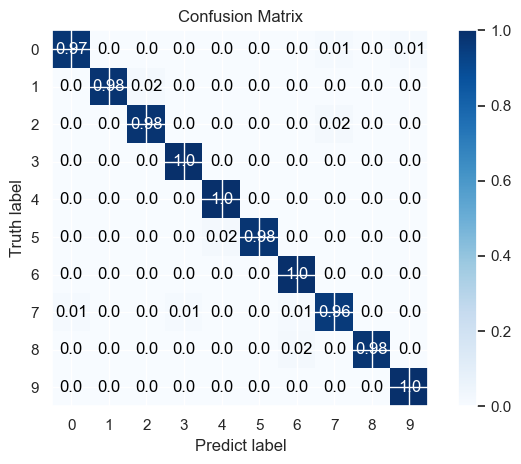

In [254]:
draw_confusion_matrix(label_true=y_true,
                      label_pred=y_pred,
                      label_name=["0", "1", "2", "3", "4", "5", "6","7","8","9"],
                      title="Confusion Matrix")